In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
from scipy import integrate

import bemcs

# Crouch and Starfield (1983) point source for a force in the $x$ direction

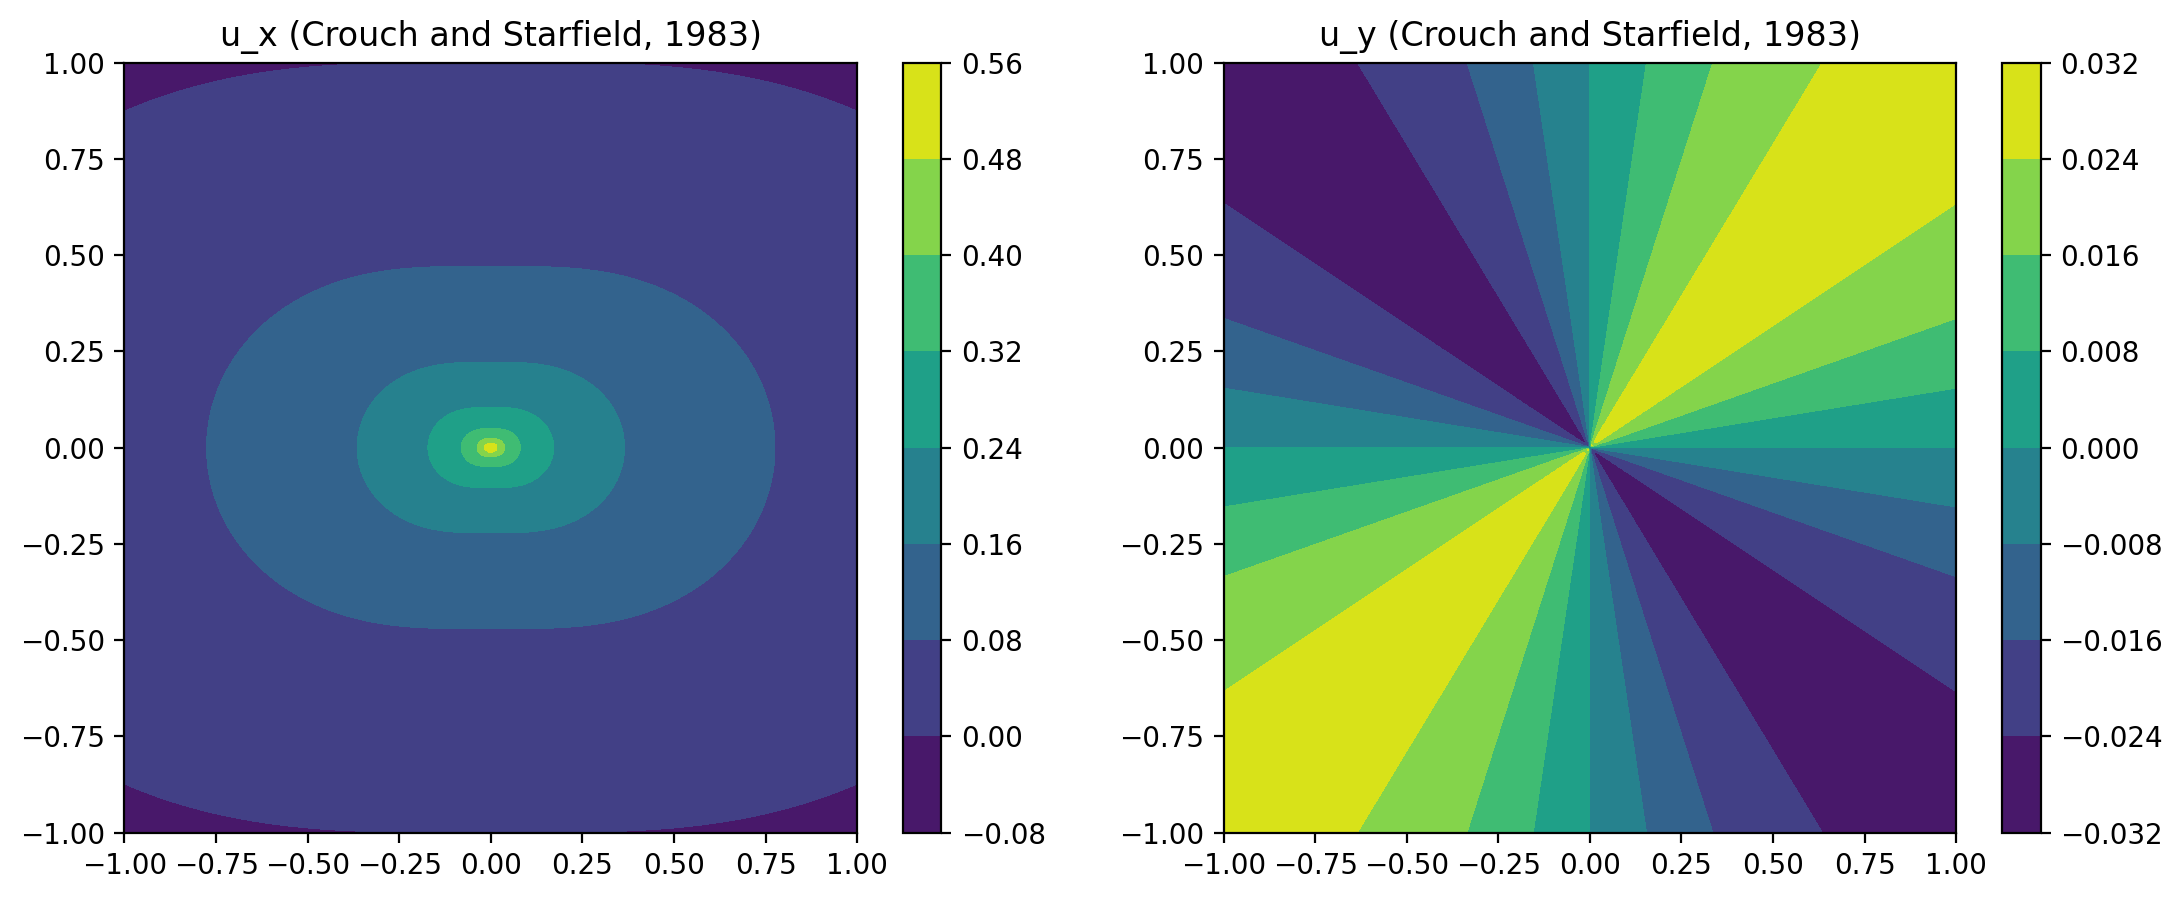

In [2]:
def kelvin_point_source(x, y, xoffset, yoffset, fx, fy, mu, nu):
    x = x - xoffset
    y = y - yoffset
    kelvin_displacements = np.zeros((len(x), 2))
    kelvin_stresses = np.zeros((len(x), 3))
    C = 1 / (4 * np.pi * (1 - nu))
    r = np.sqrt(x**2 + y**2)
    g = -C * np.log(r)
    gx = -C * x / (x**2 + y**2)
    gy = -C * y / (x**2 + y**2)
    gxy = C * 2 * x * y / (x**2 + y**2) ** 2
    gxx = C * (x**2 - y**2) / (x**2 + y**2) ** 2
    gyy = -gxx
    kelvin_displacements[:, 0] = fx / (2 * mu) * ((3 - 4 * nu) * g - x * gx) + fy / (
        2 * mu
    ) * (-y * gx)
    kelvin_displacements[:, 1] = fx / (2 * mu) * (-x * gy) + fy / (2 * mu) * (
        (3 - 4 * nu) * g - y * gy
    )
    kelvin_stresses[:, 0] = fx * (2 * (1 - nu) * gx - x * gxx) + fy * (
        2 * nu * gy - y * gxx
    )
    kelvin_stresses[:, 1] = fx * (2 * nu * gx - x * gyy) + fy * (
        2 * (1 - nu) * gy - y * gyy
    )
    kelvin_stresses[:, 2] = fx * ((1 - 2 * nu) * gy - x * gxy) + fy * (
        (1 - 2 * nu) * gx - y * gxy
    )
    return kelvin_displacements, kelvin_stresses


x_offset = 0
y_offset = 0
fx = 1
fy = 0
mu = 1
nu = 0.25
n_pts = 200
x_vec = np.linspace(-1.0, 1.0, n_pts)
y_vec = np.linspace(-1.0, 1.0, n_pts)
x_grid, y_grid = np.meshgrid(x_vec, y_vec)
kelvin_displacements, kelvin_stresses = kelvin_point_source(
    x_grid.flatten(), y_grid.flatten(), x_offset, y_offset, fx, fy, mu, nu
)
ux_kelvin = kelvin_displacements[:, 0]
uy_kelvin = kelvin_displacements[:, 1]

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.contourf(x_grid, y_grid, ux_kelvin.reshape(n_pts, n_pts))
plt.colorbar()
plt.title("u_x (Crouch and Starfield, 1983)")

plt.subplot(1, 2, 2)
plt.contourf(x_grid, y_grid, uy_kelvin.reshape(n_pts, n_pts))
plt.colorbar()
plt.title("u_y (Crouch and Starfield, 1983)")

plt.show()

## Numerical integration of point source solution
Testing `scipy.quad` to see equivalence with MATLAB's `integral()` global adaptive quadrature scheme. Seems like they work nearly identically!

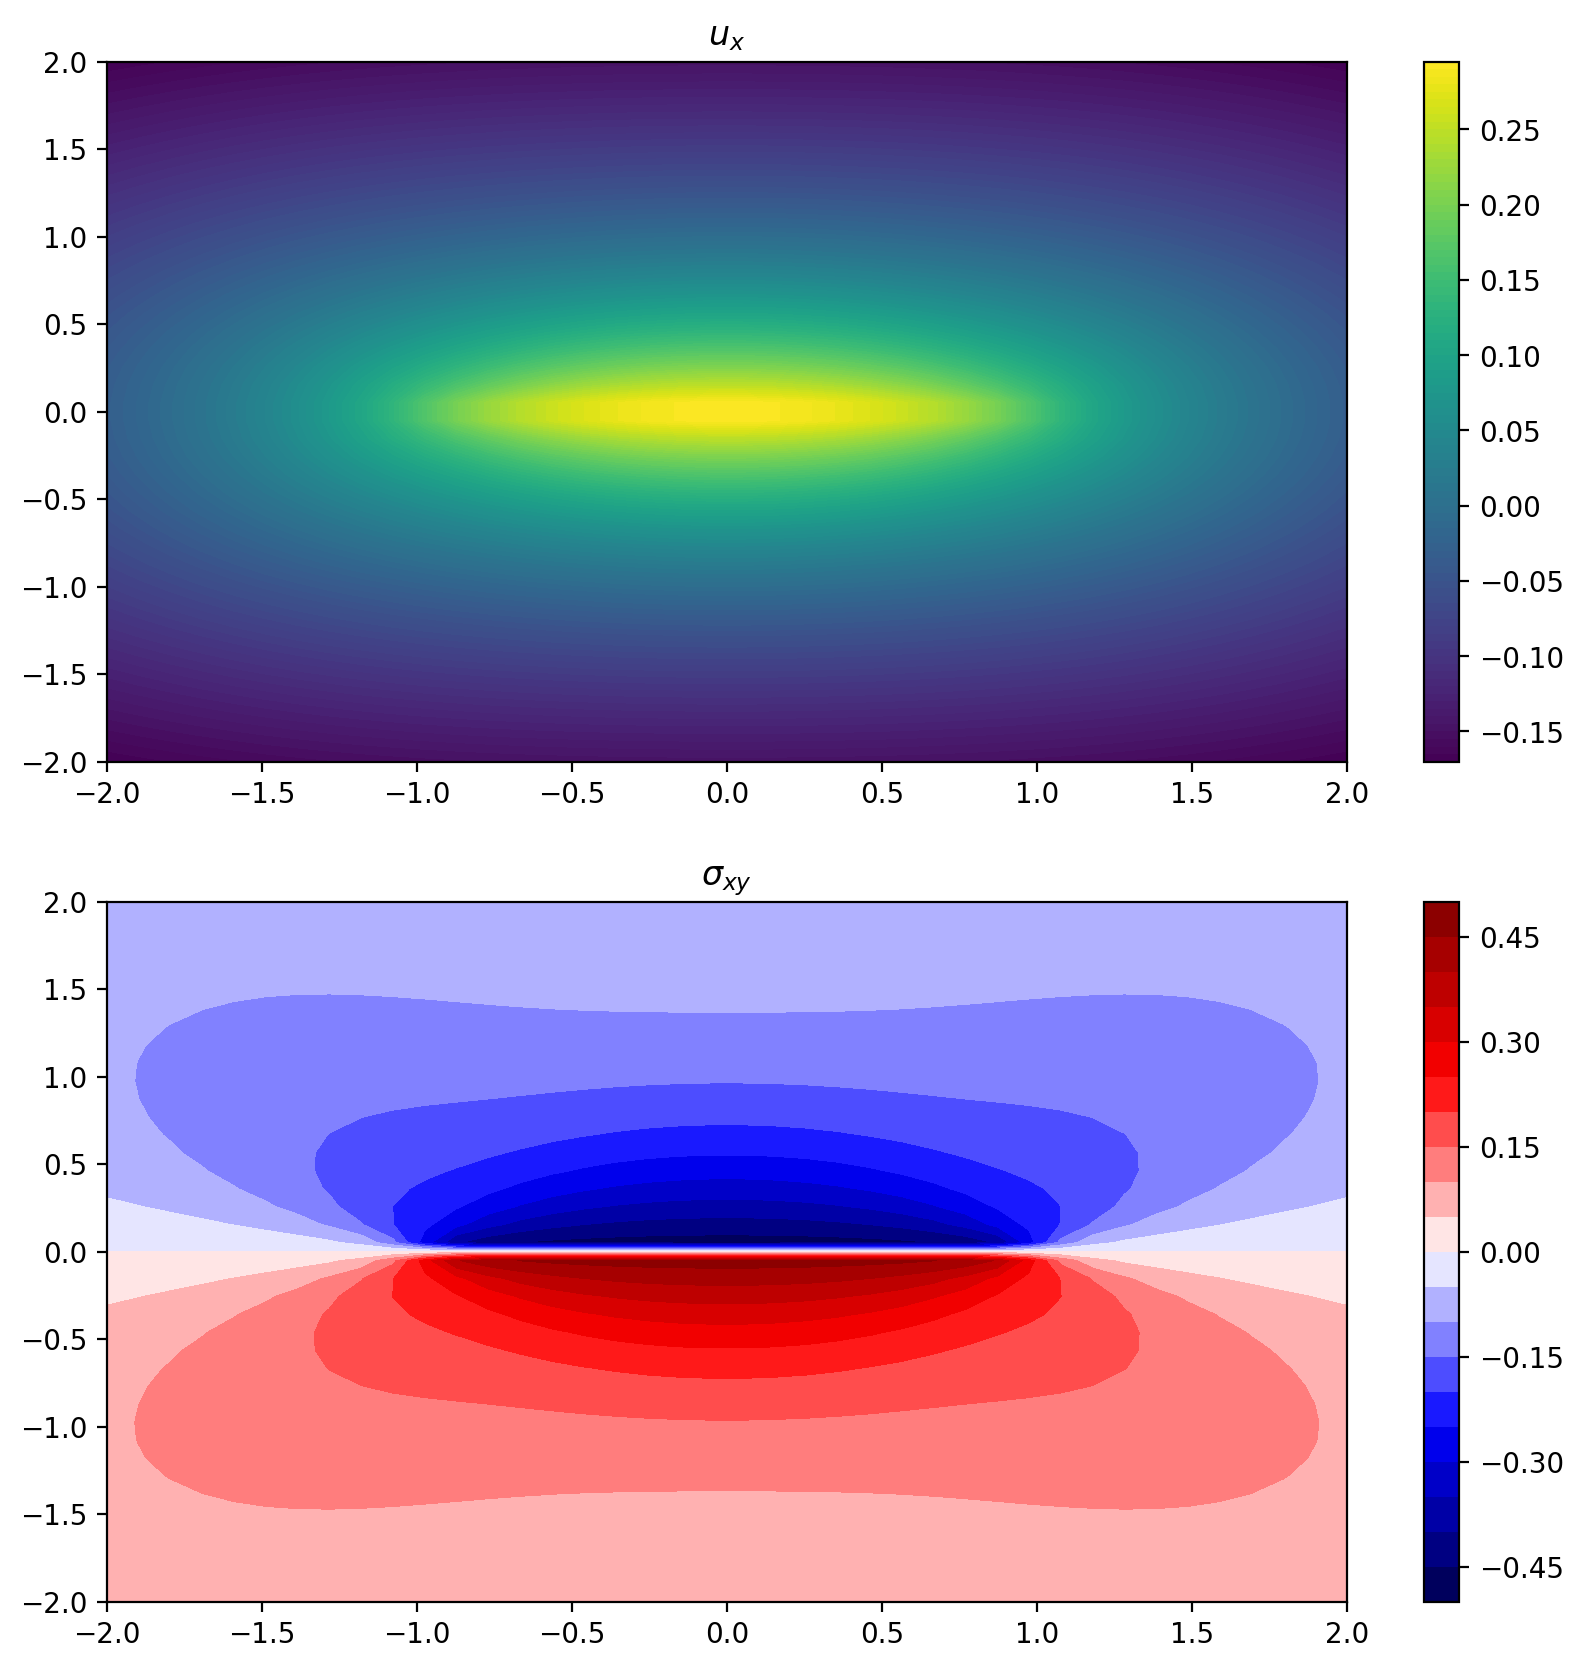

In [3]:
mu = 1
nu = 0.25
y2 = 0
y3 = 0
nx_pts = 40
ny_pts = 40
x_vec = np.linspace(-2, 2, nx_pts)
y_vec = np.linspace(-2, 2, ny_pts)
xo, yo = np.meshgrid(x_vec, y_vec)


def kelvin_point_source_disp(x, y, xoffset, yoffset, fx, fy, mu, nu):
    x = x - xoffset
    y = y - yoffset
    C = 1 / (4 * np.pi * (1 - nu))
    r = np.sqrt(x**2 + y**2)
    g = -C * np.log(r)
    gx = -C * x / (x**2 + y**2)
    gy = -C * y / (x**2 + y**2)

    ux = fx / (2 * mu) * ((3 - 4 * nu) * g - x * gx) + fy / (2 * mu) * (-y * gx)
    uy = fx / (2 * mu) * (-x * gy) + fy / (2 * mu) * ((3 - 4 * nu) * g - y * gy)
    return ux


def kelvin_point_source_stress(x, y, xoffset, yoffset, fx, fy, mu, nu):
    x = x - xoffset
    y = y - yoffset

    C = 1 / (4 * np.pi * (1 - nu))
    r = np.sqrt(x**2 + y**2)
    g = -C * np.log(r)
    gx = -C * x / (x**2 + y**2)
    gy = -C * y / (x**2 + y**2)
    gxy = C * 2 * x * y / (x**2 + y**2) ** 2
    gxx = C * (x**2 - y**2) / (x**2 + y**2) ** 2
    gyy = -gxx

    sxx = fx * (2 * (1 - nu) * gx - x * gxx) + fy * (2 * nu * gy - y * gxx)
    syy = fx * (2 * nu * gx - x * gyy) + fy * (2 * (1 - nu) * gy - y * gyy)
    sxy = fx * ((1 - 2 * nu) * gy - x * gxy) + fy * ((1 - 2 * nu) * gx - y * gxy)
    return sxy


ux = np.zeros_like(xo).flatten()
sxy = np.zeros_like(xo).flatten()
for i in range(0, xo.size):
    f = lambda x: kelvin_point_source_disp(
        xo.flatten()[i], yo.flatten()[i], x, 0, 1, 0, mu, nu
    )
    sol, err = integrate.quad(f, -1, 1)
    ux[i] = sol
    f = lambda x: kelvin_point_source_stress(
        xo.flatten()[i], yo.flatten()[i], x, 0, 1, 0, mu, nu
    )
    sol, err = integrate.quad(f, -1, 1)
    sxy[i] = sol

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.contourf(x_vec, y_vec, ux.reshape(ny_pts, nx_pts), levels=100)
plt.colorbar()
plt.title("$u_x$")
plt.subplot(2, 1, 2)
plt.contourf(x_vec, y_vec, sxy.reshape(ny_pts, nx_pts), cmap="seismic", levels=20)
plt.colorbar()
plt.title("$\sigma_{xy}$")
plt.show()

### Evaluate integral over a line along the source

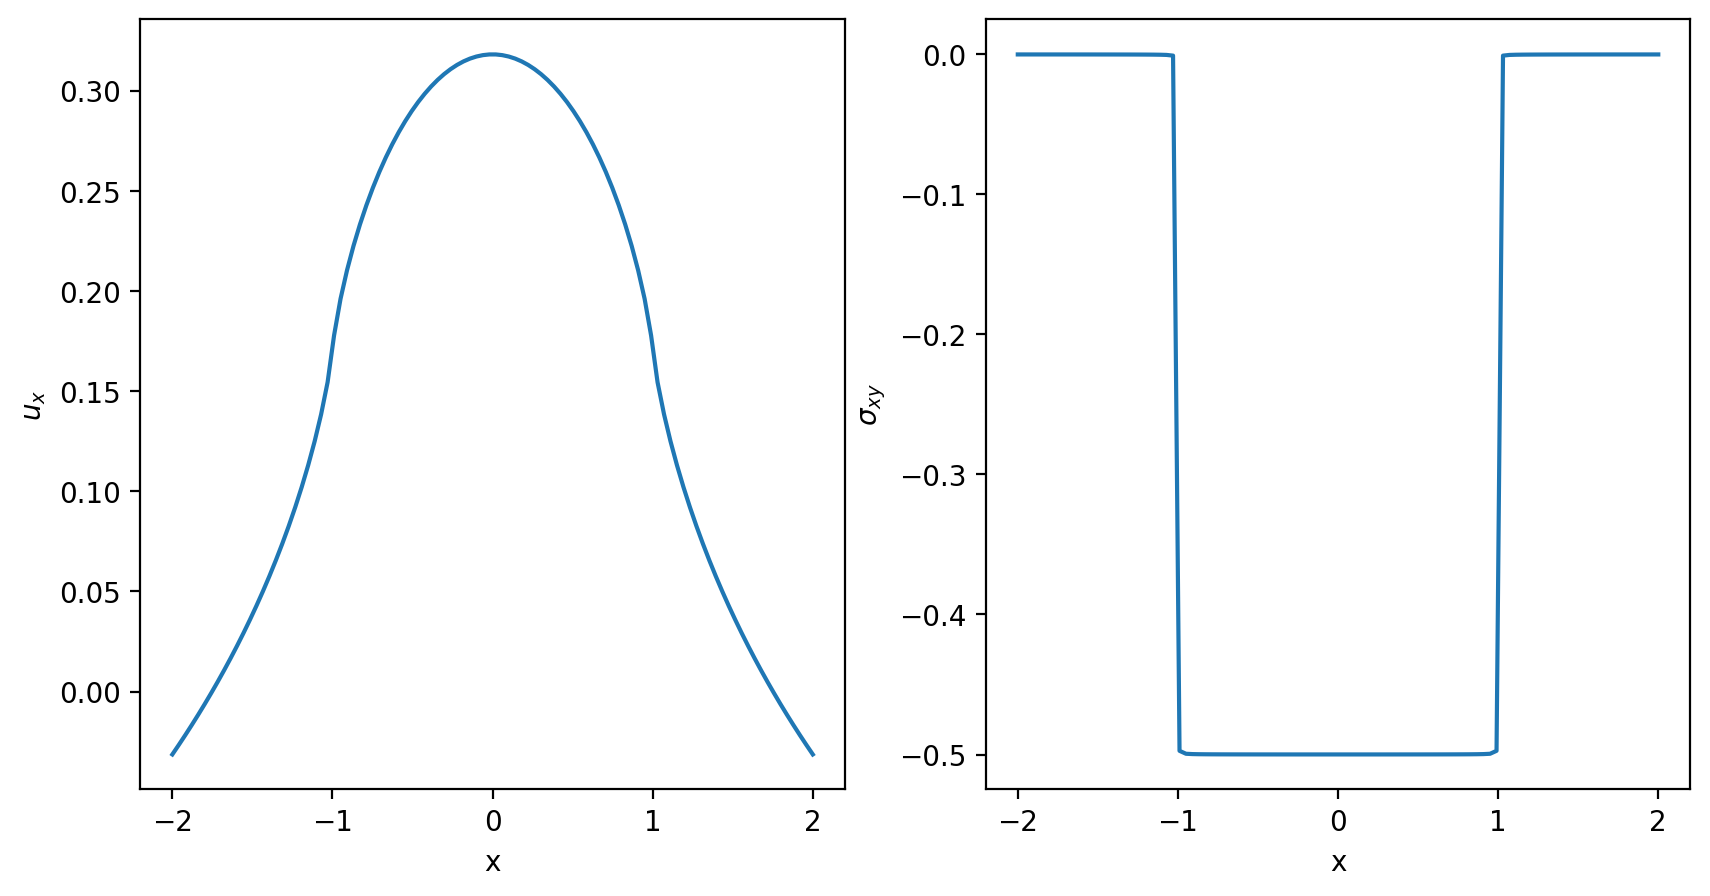

In [4]:
x_vec = np.linspace(-2, 2, 100)
yeval = 1e-4
ux = np.zeros_like(x_vec)
sxy = np.zeros_like(x_vec)
for i in range(0, x_vec.size):
    f = lambda x: kelvin_point_source_disp(x_vec[i], yeval, x, 0, 1, 0, mu, nu)
    sol, err = integrate.quad(f, -1, 1)
    ux[i] = sol
    f = lambda x: kelvin_point_source_stress(x_vec[i], yeval, x, 0, 1, 0, mu, nu)
    sol, err = integrate.quad(f, -1, 1)
    sxy[i] = sol

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x_vec, ux)
plt.xlabel("x")
plt.ylabel("$u_x$")
plt.subplot(1, 2, 2)
plt.plot(x_vec, sxy)
plt.xlabel("x")
plt.ylabel("$\sigma_{xy}$")
plt.show()

## 2-d integrals over a rectangle domain

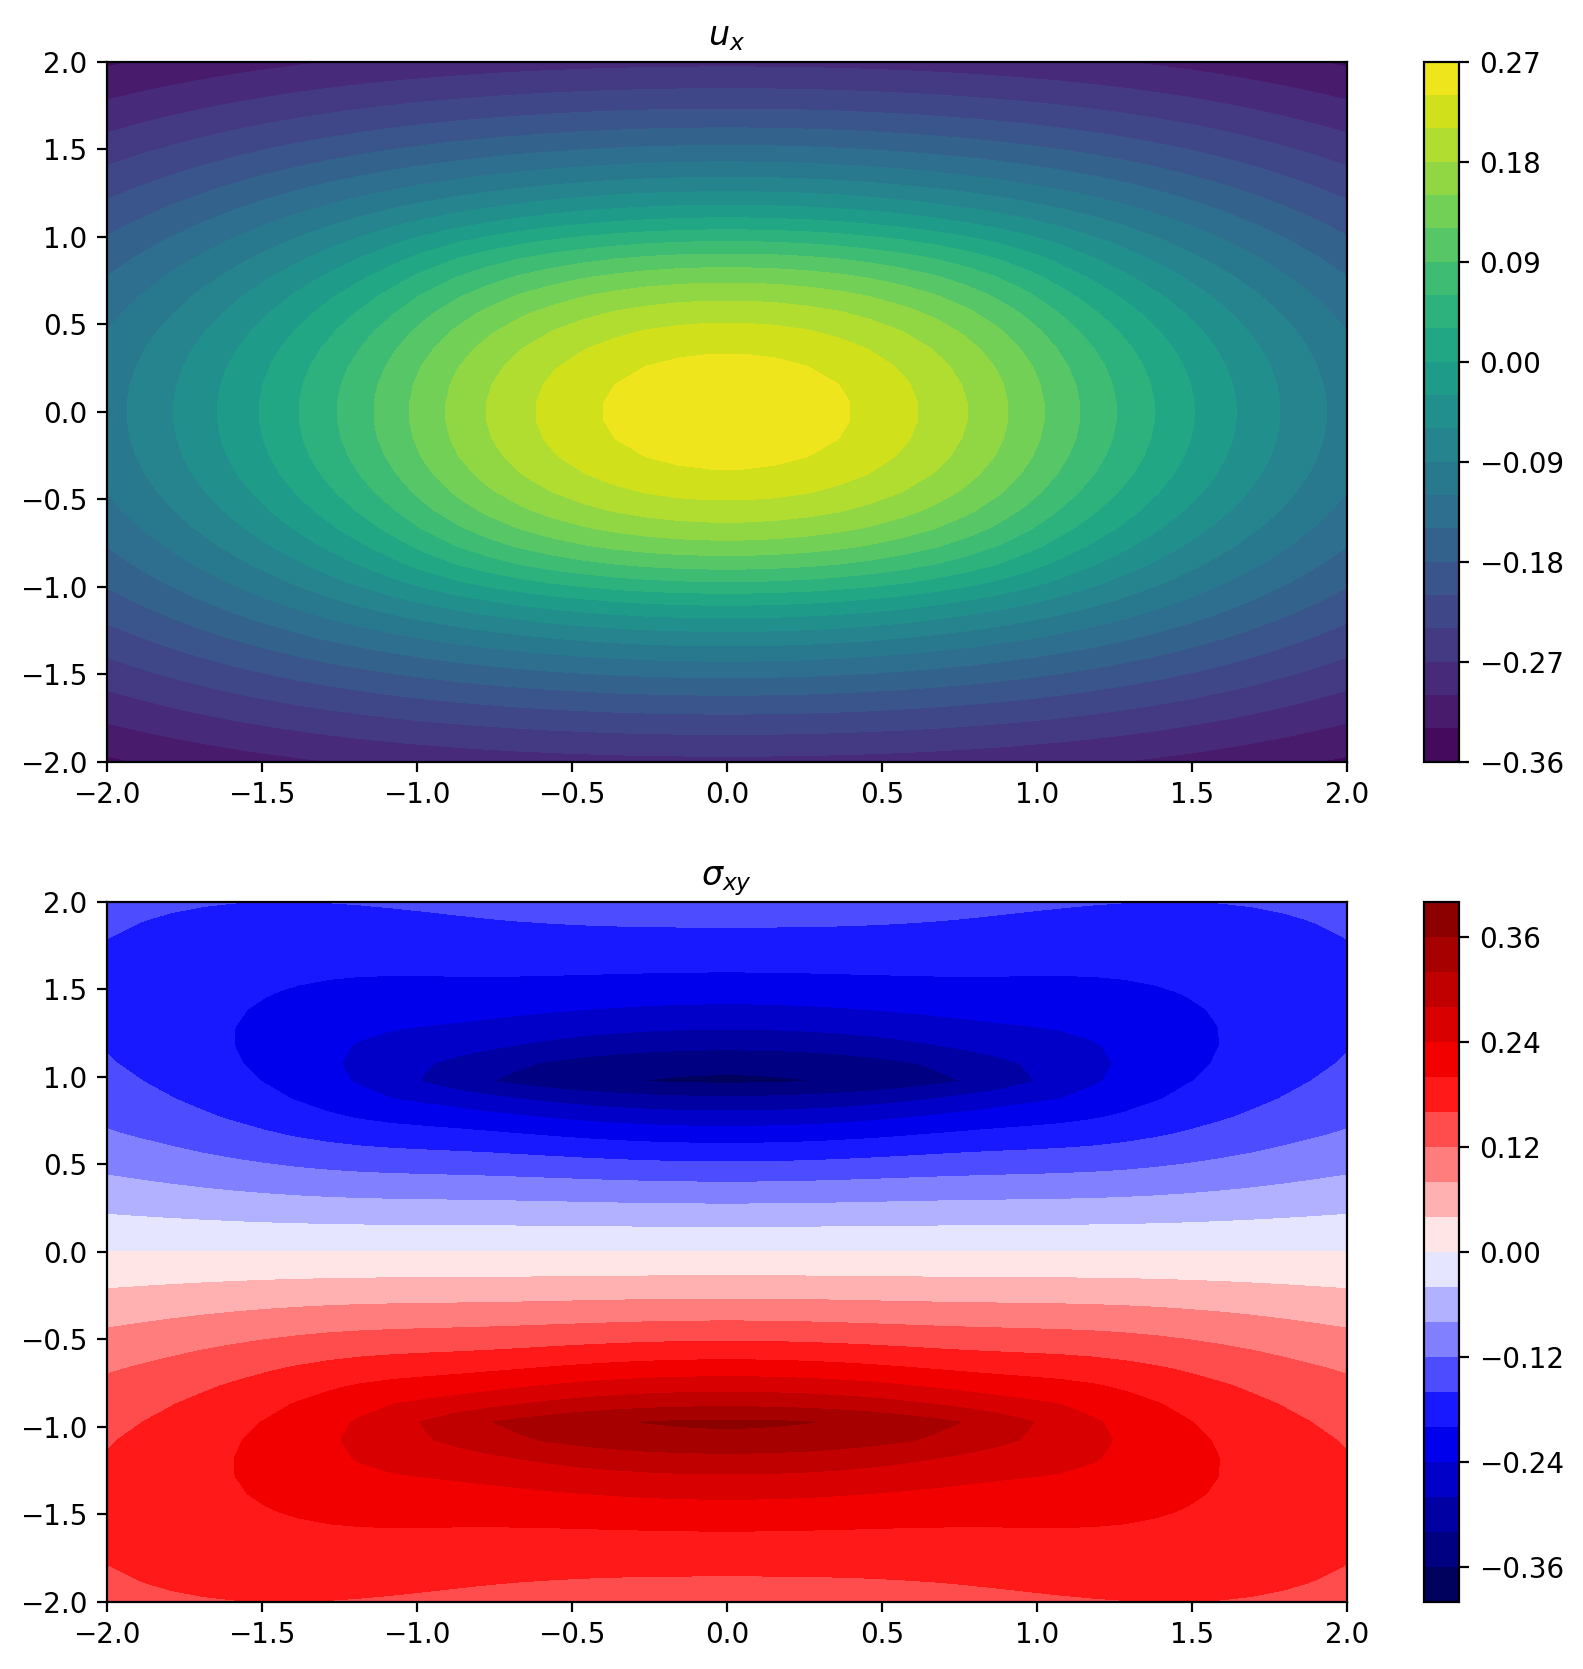

In [5]:
def singular_fun(xo, yo, xs, ys):
    r = np.sqrt((xo - xs) ** 2 + (yo - ys) ** 2)
    f = 1 / 2 / np.pi * (xo - xs) / r**2
    return f


x_vec = np.linspace(-2, 2, nx_pts)
y_vec = np.linspace(-2, 2, ny_pts)
xo, yo = np.meshgrid(x_vec, y_vec)
ux = np.zeros_like(xo).flatten()
sxy = np.zeros_like(xo).flatten()
for i in range(0, xo.size):
    # f = lambda y, x: singular_fun(xo.flatten()[i], yo.flatten()[i], x, y)
    # sol, err = integrate.dblquad(f, -1, 1, -1, 1)
    # sxy[i] = sol
    f = lambda y, x: kelvin_point_source_disp(
        xo.flatten()[i], yo.flatten()[i], x, y, 1, 0, mu, nu
    )
    sol, err = integrate.dblquad(f, -1, 1, -1, 1, epsabs=1e-3)
    ux[i] = sol
    f = lambda y, x: kelvin_point_source_stress(
        xo.flatten()[i], yo.flatten()[i], x, y, 1, 0, mu, nu
    )
    sol, err = integrate.dblquad(f, -1, 1, -1, 1, epsabs=1e-3)
    sxy[i] = sol


plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.contourf(x_vec, y_vec, ux.reshape(ny_pts, nx_pts), levels=20)
plt.colorbar()
plt.title("$u_x$")
plt.subplot(2, 1, 2)
plt.contourf(x_vec, y_vec, sxy.reshape(ny_pts, nx_pts), cmap="seismic", levels=20)
plt.colorbar()
plt.title("$\sigma_{xy}$")
plt.show()

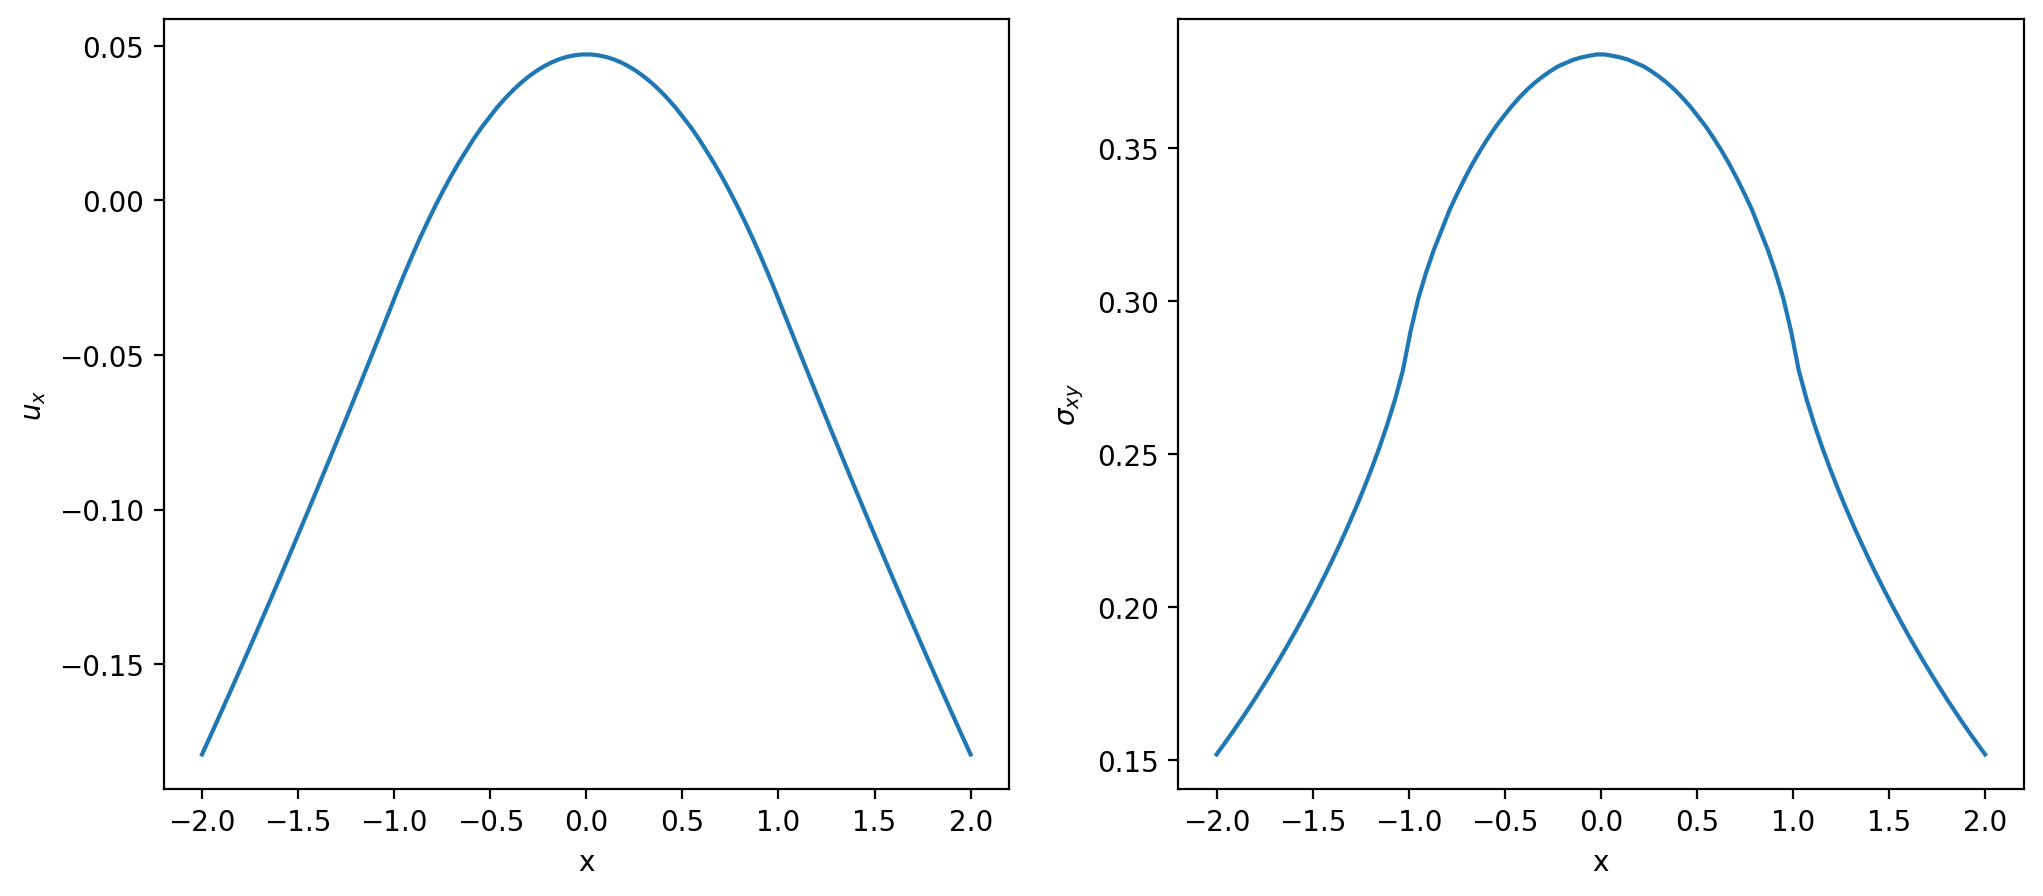

In [11]:
x_vec = np.linspace(-2, 2, 100)
yeval = -1
ux = np.zeros_like(x_vec)
sxy = np.zeros_like(x_vec)
for i in range(0, x_vec.size):
    f = lambda y, x: kelvin_point_source_disp(x_vec[i], yeval, x, y, 1, 0, mu, nu)
    sol, err = integrate.dblquad(f, -1, 1, -1, 1, epsabs=1e-3)
    ux[i] = sol
    f = lambda y, x: kelvin_point_source_stress(x_vec[i], yeval, x, y, 1, 0, mu, nu)
    # f = lambda y, x: singular_fun(x_vec[i], yeval, x, y)
    sol, err = integrate.dblquad(f, -1, 1, -1, 1, epsabs=1e-3)
    sxy[i] = sol

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_vec, ux)
plt.xlabel("x")
plt.ylabel("$u_x$")
plt.subplot(1, 2, 2)
plt.plot(x_vec, sxy)
plt.xlabel("x")
plt.ylabel("$\sigma_{xy}$")
plt.show()